# Análise de Cluster Hierárquico: 
# Elbow e Silhouette
   Legendas:
   * <code style="color:green">Teoria</code>
   * <code style="color:purple">Dicas</code>
   * <code style="color:red">Prática (exemplo ou exercício)</code>

### <code style="color:green">Cluster Hierárquico </code>
    
    Existem alguns métodos para definir a distância:
   * Vizinho mais próximo
   * Vizinho mais longe
   * Média
   * Centróide
   * Ward
    
    Podemos visualizá-los através do dendograma, que pode ser utilizado para além de visualizar o agrupamento, sugerir número de grupos (quando a distâcnia fica muito grande)
    
### <code style="color:green">Sugestão de Grupos </code> 

Podemos fazer avaliações e sugestões do número de grupos através dos métodos:   
    
   * Elbow - mede a variabilidade dentro dos grupos
   * Sillhouette - baseado nas distâncias calcula o s (varia entre -1 e 1) de cada ponto de seu grupo, além de ter o s para cada possível número de cluster a fim de sugerir um número de grupos
       
### <code style="color:purple">Discussão </code> 

Já vamos deixar alinhado que no Python o método Elbow e Sillhouete só estão automatizados para o método k-means, sendo assim, nesse código teremos funções para sanar esse ponto e conseguir calcular mesmo para o método hierarquico.
Como mencionamos, método hierárquico só funciona para poucos dados e por conta disso não recomendo utilizar o StandardScaler (da sklearn) pois ele utiliza o desvio padrão populacional, quando o mais adequado seria o desvio padrão amostral. Por conta disso fizemos uma função para isso também.

### <code style="color:purple">Inicializando pacotes e funções criadas </code> 

Carregando o que será necessário:

In [1]:
import pandas as pd # biblioteca para manipulação de dados
from scipy.spatial.distance import pdist, squareform # funções para calcular as distâncias
from scipy.cluster.hierarchy import linkage, dendrogram,fcluster # funções para clusterização
import matplotlib.pyplot as plt # biblioteca para visualização de dados
import tanglegram # biblioteca para a criação do tanglegram
from sklearn.cluster import AgglomerativeClustering # função para criar os clusters
from sklearn.metrics import silhouette_score, silhouette_samples # função para calcular a silhueta
import numpy as np # biblioteca para calculo
from sklearn.preprocessing import StandardScaler #para colocar os dados na mesma escala - atenção

Todas as funções que serão inicializadas:
    
    - mesma_escala: coloca os dados na mesma escala
    - fazer_dendograma: faz o dendograma
    - calcular_soma_quadrados_totais: função que calcula o wss para cada definição de grupos
    - grafico_elbow: função que faz o gráfico Elbow
    - s_silhouette: cria todas as medidas necessárias para silhueta
    - grafico_silhouette_por_ponto: faz o gráfico da silhueta para o s de cada ponto
    - grafico_silhouette_sugestao_grupos: faz o gráfico da silhueta para sugestão de número de grupos

O detalhamento de seus parâmetros e retornos estão comentados acima de cada função

In [2]:
#Esta função coloca os dados na mesma escala usando a equacao padrao
# (x-xbarra)/sd
# só criei isso porque o Scaler do python divide pelo desvio padrao populacional e não amostral
# em conjuntos não tão grande, isso dá muita diferença
#Parâmetros:
# -data: Conjunto de dados.
#Retorna: Conjunto de dados na mesma escala.

def mesma_escala(data):
    for col in data.columns:
        if pd.api.types.is_numeric_dtype(data[col]):
            data[col] = (data[col] - data[col].mean()) / data[col].std(ddof=1)
    return data

# Exemplo de uso
# mesma_escala(mcdonalds)

In [3]:
#Esta função cria o gráfico do dendograma conforme o método escolhido
#Parâmetros:
# -data: Conjunto de dados.
# -metodo: Método de ligação a ser utilizado na clusterização hierárquica (ex: 'average', 'ward', 'complete', 'single', 'centroid').
# -padronizar: Se seus dados não precisam ser padronizados escolher False, caso contrário, True
#Retorna:Apenas exibe o dendrograma.

def fazer_dendograma(data, metodo, padronizar):
    # Padronizando os dados, se padronizar for True
    if padronizar:
        def mesma_escala(data):
            for col in data.columns:
                if pd.api.types.is_numeric_dtype(data[col]):
                    data[col] = (data[col] - data[col].mean()) / data[col].std(ddof=1)
            return data
        base_padronizada = mesma_escala(data)
#        print("Base padronizada:")
#        print(base_padronizada.head())
        
        # Calculando a matriz de distâncias com os dados padronizados
        d = pdist(base_padronizada, metric='euclidean')
#        print("Matriz de distâncias (padronizada):")
        matriz = squareform(d)
    else:
#        print("Utilizando a base original:")
#        print(data.head())
        
        # Calculando a matriz de distâncias com os dados originais
        d = pdist(data, metric='euclidean')
#        print("Matriz de distâncias (original):")
        matriz = squareform(d)
    
    # Aplicando o linkage (clustering hierárquico)
    cluster_hierarquico = linkage(d, method=metodo)
    
    # Plotando o dendrograma
    plt.figure(figsize=(5, 3))
    plt.title(f"Dendrograma usando {metodo.capitalize()} linkage")
    
    # Exibindo o dendrograma com os rótulos da base de dados
    dendrogram(cluster_hierarquico, labels=data.index)
    
    # Rotacionando os rótulos no eixo x
    plt.xticks(rotation=90)
    
    # Exibindo o gráfico
    plt.show()

# Exemplo de uso
# fazer_dendograma(mcdonalds, metodo='single', padronizar=True)


In [4]:
#Esta função calcula a soma dos quadrados totais (SQT) para cada variável dentro de cada cluster.
# Retorna o calculo passo a passo e uma tabela com a SQT de cada variável,
# além do valor total da soma dos quadrados.
#Parâmetros:
#    - data: Conjunto de dados.
#    - grupos: Um vetor que indica a qual cluster cada observação pertence.
#    - verbose: Se True, imprime informações detalhadas sobre o cálculo.
#Retorna:
#    - Uma tabela com a SQT de cada variável por cluster.
#    - O valor total da soma dos quadrados (WSS).

def calcular_soma_quadrados_totais(data, grupos, verbose):

    sqt_total = 0
    resultado = []

    if verbose:
        print(f"Dados recebidos: \n{data}")
        print(f"Grupos recebidos: \n{grupos}")
    
    # Percorrendo cluster a cluster (grupo a grupo)
    for cluster_gerado in np.unique(grupos):
        if verbose:
            print(f"\nProcessando o cluster {cluster_gerado}...")
        
        # Filtrando os dados do cluster atual
        cluster_data = data[grupos == cluster_gerado]
        
        if verbose:
            print(f"Dados do cluster {cluster_gerado}: \n{cluster_data}")
        
        # Verificando se o cluster tem pelo menos 1 ponto
        if len(cluster_data) > 0:
            # Calculando o centroide (média de cada variável)
            centroide = np.mean(cluster_data, axis=0)
            if verbose:
                print(f"Centroide do cluster {cluster_gerado}: \n{centroide}")
            
            # Calculando a soma dos quadrados para cada variável
            sqt_variaveis = np.sum((cluster_data - centroide) ** 2, axis=0)
            if verbose:
                print(f"SQT das variáveis para o cluster {cluster_gerado}: \n{sqt_variaveis}")
            
            # Armazenando o resultado para cada cluster e variável
            resultado.append(sqt_variaveis)
            
            # Soma dos quadrados dentro do cluster (WSS para o cluster)
            sqt_total += np.sum(np.linalg.norm(cluster_data - centroide, axis=1)**2)
        else:
            resultado.append([np.nan] * data.shape[1])  # Caso de cluster vazio
    
    # Convertendo o resultado para um DataFrame
    df_resultado = pd.DataFrame(np.vstack(resultado), columns=[f'Variável {i+1}' for i in range(data.shape[1])])
    df_resultado.index = [f'Cluster {int(c)}' for c in np.unique(grupos)]
    
    if verbose:
        # Imprimindo o valor total da soma dos quadrados
        print(f"\nSoma total dos quadrados (WSS): {sqt_total}")
    
    return df_resultado, sqt_total

# Exemplo de uso
#roda o método que te interessa
#mcdonalds_padronizado = mesma_escala(mcdonalds)
#d = pdist(mcdonalds_padronizado, metric='euclidean')
#cluster_hierarquico = linkage(d, method='single')
#marca os grupos
#grupos = fcluster(cluster_hierarquico , t=2, criterion='maxclust')
#grupos
#chama a função
#df_resultado, wss_total = calcular_soma_quadrados_totais(mcdonalds_padronizado, grupos, verbose=True)
# Exibir a tabela de resultados
#print(df_resultado)
#print(f"\nSoma total dos quadrados (WSS):", wss_total)
#print(grupos)

In [5]:
#Esta função faz o cluster hierárquico com o método definido, calcula a soma dos quadrados totais (SQT)
#para diferentes números de clusters e plota o gráfico do método do cotovelo (Elbow).
#Parâmetros:
# - data: Conjunto de dados.
# - metodo: Método de ligação a ser utilizado na clusterização hierárquica (ex: 'average', 'ward', 'complete', 'single', 'centroid').
# - max_clusters: O número máximo de clusters a ser considerado no cálculo, ou seja, vai calcular para todos os clusters até este valor.
# - padronizar: Se seus dados não precisam ser padronizados escolher False, caso contrário, True
# importante documentar que se os dados forem padronizados (necessário quando tem escalas diferentes)
# o SQT será calculado com os dados padronizados.
#Retorna:
#    - Plota o gráfico do método do cotovelo para o número de clusters.

def grafico_elbow(data, metodo, max_clusters, padronizar):
    # Verifica se os dados devem ser padronizados
    if padronizar:
        def mesma_escala(data):
            for col in data.columns:
                if pd.api.types.is_numeric_dtype(data[col]):
                    data[col] = (data[col] - data[col].mean()) / data[col].std(ddof=1)
            return data
        data_utilizado = mesma_escala(data)
    else:
        print("Usando os dados originais...")
        data_utilizado = data
    
    # Criar o linkage (cluster_hierarquico) com o método especificado
    cluster_hierarquico = linkage(data_utilizado, method=metodo)
    
    # Lista para armazenar os valores de SQT
    sqt = []
    
    # Calcular SQT para diferentes números de clusters
    for n_clusters in range(1, max_clusters + 1):
        grupos = fcluster(cluster_hierarquico, t=n_clusters, criterion='maxclust')
        
        if n_clusters > 1:
            # A função 'calcular_soma_quadrados_totais' retorna dois valores, o WSS 
            # está na segunda posição
            _, wss_total = calcular_soma_quadrados_totais(data_utilizado, grupos, verbose=False)
            sqt.append(wss_total)
        else:
            sqt.append(np.nan)  # Para o caso de n_clusters = 1
    
    # Plotar o gráfico do método do cotovelo (Elbow)
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_clusters + 1), sqt, marker='o')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Soma dos Quadrados das Distâncias')
    plt.title(f'Elbow para Clustering Hierárquico pelo método {metodo.capitalize()}')
    plt.show()

# Exemplo de uso
#grafico_elbow(mcdonalds, metodo='average', max_clusters=10, padronizar = False)

In [6]:
#Esta função faz o cluster hierárquico com o método definido e calcula o a_i, b_i, s_i, s_k para cada k cluster criados
#a ideia aqui é ter uma função que faz todas as contas necessárias para silhueta, a fim de armazenar um df.
#Parâmetros:
# - data: Conjunto de dados.
# - metodo: Método de ligação a ser utilizado na clusterização hierárquica (ex: 'average', 'ward', 'complete', 'single', 'centroid').
# - max_clusters: O número máximo de clusters a ser considerado no cálculo, ou seja, vai calcular para todos os clusters até este valor.
# - padronizar: Se seus dados não precisam ser padronizados escolher False, caso contrário, True
# importante documentar que se os dados forem padronizados (necessário quando tem escalas diferentes)
# a silhueta será calculado com os dados padronizados.
#Retorna:
#    - df_silhueta: DataFrame contendo os resultados (label_ponto, grupo, a_i, b_i, s_i, s_k, k).

def s_silhouette(data, metodo, max_clusters, padronizar):

    # Se padronizar for True, padroniza os dados
    if padronizar:
        def mesma_escala(data):
            for col in data.columns:
                if pd.api.types.is_numeric_dtype(data[col]):
                    data[col] = (data[col] - data[col].mean()) / data[col].std(ddof=1)
            return data
        data_padronizada = mesma_escala(data)
        d = pdist(data_padronizada, metric='euclidean')
        print("Dados padronizados para clustering")
    else:
        d = pdist(data, metric='euclidean')
        print("Dados originais utilizados para clustering")
    
    # Convertendo a matriz de distâncias para formato quadrado (necessária para silhouette)
    d_square = squareform(d)
    
    # Criando a lista para armazenar os resultados de cada k
    silhueta = []
    
    # Rodando o clustering hierárquico uma vez
    cluster_hierarquico = linkage(d, method=metodo)

    # Iterando para cada valor de k (de 2 até max_clusters)
    for k in range(2, max_clusters + 1):
        grupos = fcluster(cluster_hierarquico, t=k, criterion='maxclust')

        # Calculando a e b para cada ponto usando a função calc_a_b
        a_vals, b_vals = calc_a_b(d_square, grupos, np.unique(grupos))

        # Calculando silhouette para cada ponto, com a regra de cluster único
        silhouette_vals = []
        for a_i, b_i, grupo in zip(a_vals, b_vals, grupos):
            # Se o ponto está sozinho no cluster, defina silhueta como 0
            if np.sum(grupos == grupo) == 1:
                silhouette_vals.append(0)
            else:
                silhouette_vals.append((b_i - a_i) / max(a_i, b_i) if max(a_i, b_i) != 0 else 0)

        # Calculando a média das silhuetas
        silhouette_avg = np.mean(silhouette_vals)

        # Criando DataFrame temporário para armazenar os resultados
        df_k = pd.DataFrame({
            'label_ponto': data.index,
            'grupo': grupos,
            'a_i': a_vals,
            'b_i': b_vals,
            's_i': silhouette_vals,
            's_k': silhouette_avg,
            'k': [k] * len(grupos)  # Adiciona o valor de k em todas as linhas
        })

        # Adiciona o DataFrame resultante na lista de resultados
        silhueta.append(df_k)
    
    # Concatenando todos os DataFrames gerados para cada valor de k
    df_silhueta = pd.concat(silhueta, ignore_index=True)

    return df_silhueta


# Função para calcular as distâncias intra-cluster (a) e inter-cluster (b)
def calc_a_b(d_matrix, clusters, cluster_id):
    a_values = []
    b_values = []
    for i in range(len(clusters)):
        same_cluster = np.where(clusters == clusters[i])[0]
        other_clusters = np.where(clusters != clusters[i])[0]
        
        # Distância média para o mesmo cluster (a)
        if len(same_cluster) > 1:
            a = np.mean([d_matrix[i, j] for j in same_cluster if i != j])
        else:
            a = 0  # Se não houver outro ponto no cluster, a = 0
        a_values.append(a)
        
        # Distância média para o cluster mais próximo (b)
        b = np.min([np.mean([d_matrix[i, j] for j in np.where(clusters == c)[0]]) 
                    for c in np.unique(clusters) if c != clusters[i]])
        b_values.append(b)
    
    return a_values, b_values

# Exemplo de uso
#df_silhueta = s_silhouette(mcdonalds, metodo='average', max_clusters=11, padronizar=True)
#df_silhueta

In [7]:
#Esta função cria o gráfico da silhueta para o s de cada ponto
#Parâmetros:
#  df_silhueta : DataFrame obtido na função anterior contendo os resultados de silhueta para cada número de clusters.
#Retorna: Apenas exibe o gráfico da silhueta.

def grafico_silhouette_por_ponto(df_silhueta):
    # Obter os valores únicos de k
    k_values = df_silhueta['k'].unique()
    
    # Definir o número de colunas para o layout dos gráficos
    num_cols = len(k_values)
    
    # Criar um gráfico para cada valor de k
    fig, axes = plt.subplots(1, num_cols, figsize=(15, 6), sharey=False)
    
    # Caso tenha apenas 1 valor de k, evitar erro na iteração
    if num_cols == 1:
        axes = [axes]  # Transformar o único eixo em lista

    for i, k in enumerate(k_values):
        # Filtrar o dataframe para o valor de k
        df_k = df_silhueta[df_silhueta['k'] == k]
        
        # Criar gráfico de barras horizontais sem ordenar os valores
        axes[i].barh(df_k['label_ponto'], df_k['s_i'], color='lightblue', edgecolor='black')
        
        # Adicionar linha pontilhada para o valor de s_k
        axes[i].axvline(x=df_k['s_k'].values[0], color='red', linestyle='--', label=f's_k = {df_k["s_k"].values[0]:.3f}')
        
        # Adicionar linha pontilhada para a média
        axes[i].axvline(x=0, color='blue', linestyle='-')
        
        # Definir título e labels
        axes[i].set_title(f'k = {k}')
        axes[i].set_xlabel('Valor de s_i')
        
        # Mostrar as labels do eixo y para todos os gráficos
#        axes[i].set_yticks(df_k['label_ponto'])
#        axes[i].set_yticklabels(df_k['label_ponto'])
 
        # Mostrar as labels do eixo Y apenas no primeiro gráfico
        if i == 0:
            axes[i].set_yticks(df_k['label_ponto'])
            axes[i].set_yticklabels(df_k['label_ponto'])
        else:
            axes[i].set_yticks([])
            axes[i].set_yticklabels([])
            
    # Ajustar layout
    plt.tight_layout()
    plt.show()

# Exemplo de uso
#grafico_silhouette_por_ponto(df_silhueta)


In [8]:
#Esta função cria o gráfico da silhueta para sugestão de número de grupos
#Parâmetros:
#  df_silhueta : DataFrame obtido na função anterior contendo os resultados de silhueta para cada número de clusters.
#Retorna: Apenas exibe o gráfico da silhueta.

def grafico_silhouette_sugestao_grupos(df_silhueta):
    # Encontrar o valor máximo de s_k
    max_s_k = df_silhueta['s_k'].max()
    
    # Encontrar o menor k correspondente ao maior valor de s_k
    min_k_with_max_s_k = df_silhueta[df_silhueta['s_k'] == max_s_k]['k'].min()
    
    # Plotar o gráfico
    plt.figure(figsize=(10, 6))
    plt.plot(df_silhueta['k'], df_silhueta['s_k'], marker='o', linestyle='-', color='b')
    
    # Adicionar uma linha vertical pontilhada no menor k com s_k máximo
    plt.axvline(x=min_k_with_max_s_k, color='r', linestyle='--', label=f'k = {min_k_with_max_s_k}')
    
    # Títulos e rótulos dos eixos
    plt.title('Gráfico da Silhueta')
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Silhueta')
    
    # Adicionar legenda
    plt.legend()
    
    # Mostrar o gráfico
    plt.show()

# Exemplo de uso
#grafico_silhouette_sugestao_grupos(df_silhueta)


### <code style="color:purple">Começar a análise </code> 

Deixando à mão como chamar cada função:
    
    - mesma_escala: coloca os dados na mesma escala
    mesma_escala(mcdonalds)
    
    - fazer_dendograma: faz o dendograma
    fazer_dendograma(mcdonalds, metodo='single', padronizar=True)
    
    - calcular_soma_quadrados_totais: função que calcula o wss para cada definição de grupos
    
    - grafico_elbow: função que faz o gráfico Elbow
    grafico_elbow(mcdonalds, metodo='average', max_clusters=10, padronizar = True)
    
    - s_silhouette: cria todas as medidas necessárias para silhueta
    df_silhueta = s_silhouette(mcdonalds, metodo='average', max_clusters=10, padronizar=True)
    
    - grafico_silhouette_por_ponto: faz o gráfico da silhueta para o s de cada ponto
    grafico_silhouette_por_ponto(df_silhueta)
    
    - grafico_silhouette_sugestao_grupos: faz o gráfico da silhueta para sugestão de número de grupos
    grafico_silhouette_sugestao_grupos(df_silhueta)

### <code style="color:green">Importando os dados</code> 

Importando e trabalhando no conjunto de dados:  

In [9]:
# importando o arquivo
alunos_pap = pd.read_csv("dados/alunos_pap2.csv", sep=";", decimal=",")
#colocando o nome do aluno como índice
alunos_pap.set_index(alunos_pap.columns[0], inplace=True)
#poderia fazer assim tambem
#alunos_pap.index = alunos_pap["Aluno"]
#alunos_pap = alunos_pap.drop(["Aluno"],axis = 1)
alunos_pap.head()

,Matematica,Portugues
Aluno,,
A,9,7
B,5,4
C,6,6
D,10,8
E,4,4


In [ ]:
#calculando matrix de distancias distancia
#d = pdist(alunos_pap, metric='euclidean')
#d
#caso queira ver a matriz mais bonitinha
#matriz = squareform(d)
#pd.DataFrame(matriz, index=alunos_pap.index, columns= alunos_pap.index)

### <code style="color:green">Dendograma</code> 

Visualizando o dendograma:  

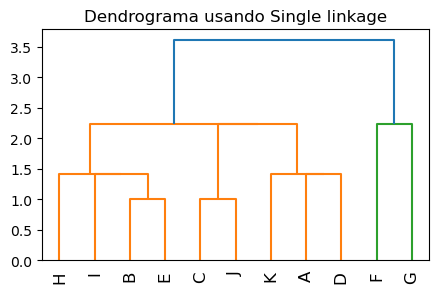

In [11]:
#observando o dendograma
fazer_dendograma(alunos_pap, metodo='single', padronizar=False)

### <code style="color:green">Gráfico Elbow </code> 

Constrindo o gráfico de Elbow para o método hierárquico conforme o método da sua escolha:   

Usando os dados originais...


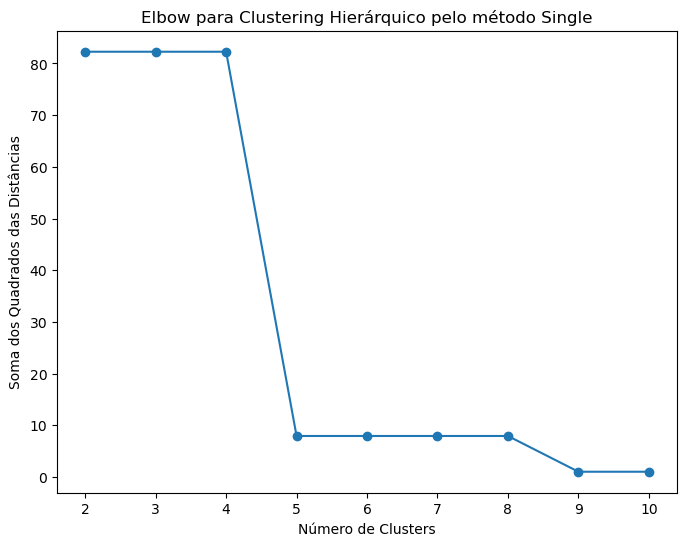

In [12]:
# Usando a função conforme o que desejar
grafico_elbow(alunos_pap, metodo='single', max_clusters=10, padronizar = False)

### <code style="color:green">Medidas para Silhueta</code> 

Calculando a_i, b_i, s_i, s_k para diferentes k's:

In [13]:
# chamando a funcao para calcular o a_i, b_i, s_i e s_k base de dados
df_silhueta = s_silhouette(alunos_pap, metodo='single', max_clusters=10, padronizar=False)
# Exibindo os resultados
#caso queira ver todas as linhas da tabela
pd.set_option('display.max_rows', None)
df_silhueta
#df_silhueta[df_silhueta['k']==5]
#df_silhueta[['s_k', 'k']].drop_duplicates()

Dados originais utilizados para clustering


,label_ponto,grupo,a_i,b_i,s_i,s_k,k
0,A,1,3.880829,6.228116,0.376886,0.355429,2
1,B,1,3.410620,5.049510,0.324564,0.355429,2
2,C,1,3.133082,4.038844,0.224263,0.355429,2
3,D,1,4.841714,7.041381,0.312391,0.355429,2
4,E,1,4.002405,4.736068,0.154910,0.355429,2
5,F,2,2.236068,5.312307,0.579078,0.355429,2
6,G,2,2.236068,6.064767,0.631302,0.355429,2
7,H,1,4.565144,6.889636,0.337390,0.355429,2
8,I,1,3.667263,6.363840,0.423734,0.355429,2
9,J,1,3.064445,4.813903,0.363418,0.355429,2


### <code style="color:green">Silhueta recomendação de grupos </code> 

Constrindo o gráfico de Silhueta para o método hierárquico conforme o método da sua escolha:  

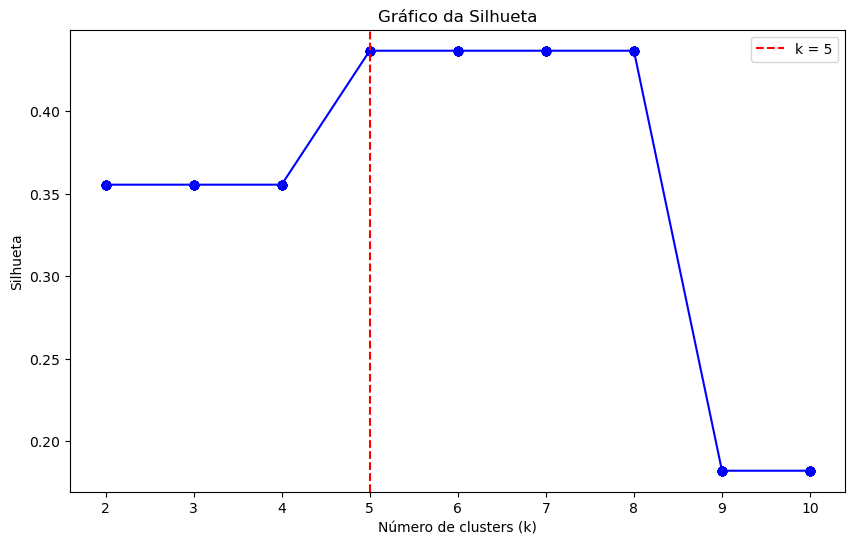

In [14]:
grafico_silhouette_sugestao_grupos(df_silhueta)

### <code style="color:green">Silhueta individuais </code> 

Constrindo o gráfico da silhueta indivudual:

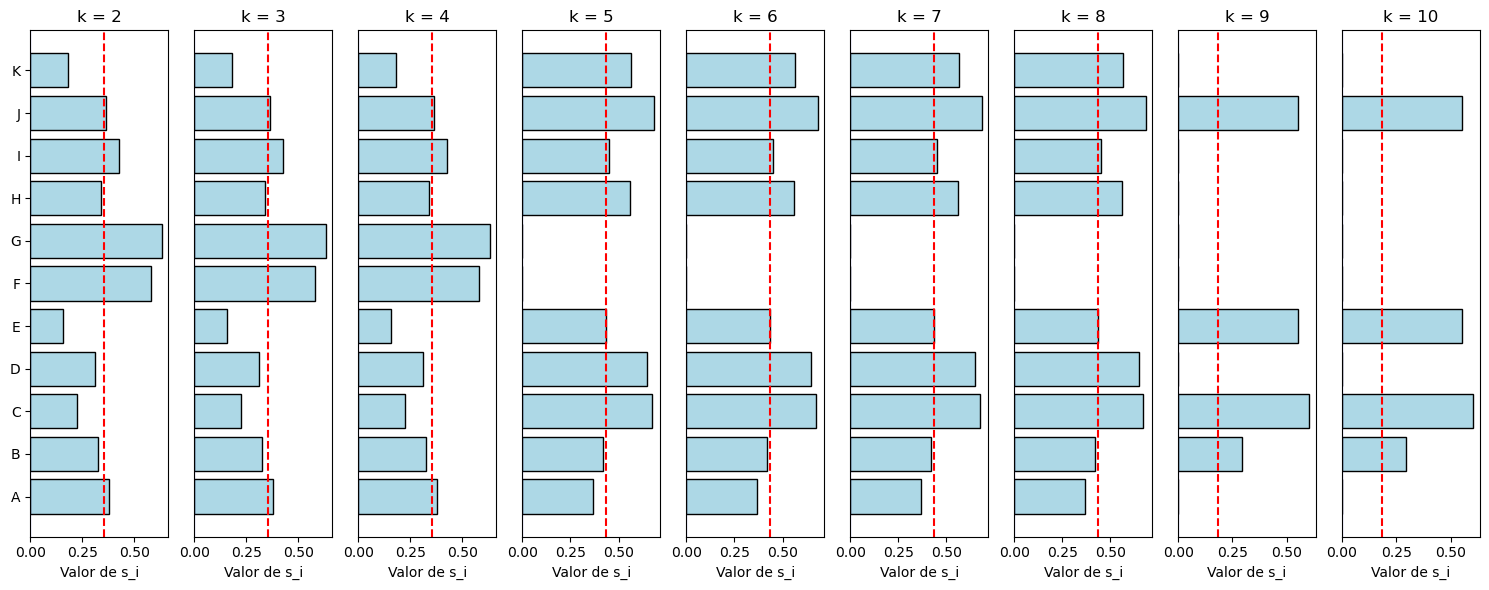

In [15]:
grafico_silhouette_por_ponto(df_silhueta)